In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
import lightgbm as lgb
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import shapiro


from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import IsolationForest

from scipy.stats import genextreme
import numpy as np

from sklearn.pipeline import Pipeline

from tensorflow.keras.layers import Conv2D, Dropout, Input, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Embedding, LSTM,MaxPool2D, Dropout, Conv1D, MaxPooling1D, LSTM, concatenate
from tensorflow.keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import GlorotUniform
import tensorflow as tf
import os
import random as python_random

from imblearn.over_sampling import SMOTE
import time

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
def random_seed_function(seed = 345):
  # Set random seed for numpy
  np.random.seed(seed)
  # Set random seed for python
  python_random.seed(seed)
  # Set random seed for tensorflow
  tf.random.set_seed(seed)
  # Set environment variable for reproducibility
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # GPU service
  os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
path_data = "/content/drive/MyDrive/Research (Dr Inam Ullah - PHD)/"

## First Dataset IoTID20

In [ ]:
df_IoTID20 = pd.read_csv(path_data + "IoT_2020_b_0.01.csv")
df_IoTID20

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Timestamp,Flow_Duration,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Bwd_Pkt_Len_Max,...,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Std,FIN_Flag_Cnt,Pkt_Size_Avg,Init_Bwd_Win_Byts,Idle_Mean,Idle_Max,Idle_Min,Label
0,12708,25886,53190,200,9020,3760,124,0.0,2776.0,1388.0,...,0.00,16129.03,0.00,0,2082.0,1869,124.00,124.0,124.0,1
1,60,25883,60357,110,7760,3649,46189,2528.0,0.0,0.0,...,43.30,43.30,698.97,0,632.0,126,15396.33,40225.0,1910.0,1
2,12695,25883,9020,203,52739,2261,73,1388.0,1388.0,1388.0,...,13698.63,13698.63,0.00,0,2082.0,1869,73.00,73.0,73.0,1
3,12690,25886,52717,200,9020,1963,149,0.0,0.0,0.0,...,13422.82,6711.41,0.00,0,0.0,32679,74.50,75.0,74.0,1
4,12690,25886,52717,200,9020,1905,83,0.0,0.0,0.0,...,12048.19,12048.19,0.00,0,0.0,32422,83.00,83.0,83.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6247,12659,25886,10125,200,9020,1057,70,0.0,2776.0,1388.0,...,0.00,28571.43,0.00,0,2082.0,1869,70.00,70.0,70.0,1
6248,13708,25883,60158,233,8899,3264,40,128.0,32.0,32.0,...,100000.00,25000.00,0.00,0,38.4,-1,10.00,21.0,5.0,1
6249,7655,15614,8487,200,554,3697,1283,0.0,0.0,0.0,...,0.00,1558.85,0.00,0,0.0,14600,1283.00,1283.0,1283.0,1
6250,62696,25889,64783,233,9988,3192,222,96.0,32.0,32.0,...,13513.51,4504.50,0.00,0,40.0,-1,74.00,206.0,8.0,1


# 1. Automated Data Pre-Processing

## Automated Transformation/Encoding
Automatically identify and transform string/text features into numerical features to make the data more readable by ML models

In [ ]:
# Define the automated data encoding function
def Auto_Encoding(df_IoTID20):
    cat_features=[x for x in df_IoTID20.columns if df_IoTID20[x].dtype=="object"] ## Find string/text features
    le=LabelEncoder()
    for col in cat_features:
        if col in df_IoTID20.columns:
            i = df_IoTID20.columns.get_loc(col)
            # Transform to numerical features
            df_IoTID20.iloc[:,i] = df_IoTID20.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')
    return df_IoTID20

In [ ]:
df_IoTID20=Auto_Encoding(df_IoTID20)

## Automated Imputation
Detect and impute missing values to improve data quality

In [ ]:
# Define the automated data imputation function
def Auto_Imputation(df_IoTID20):
    if df_IoTID20.isnull().values.any() or np.isinf(df_IoTID20).values.any(): # if there is any empty or infinite values
        df_IoTID20.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_IoTID20.fillna(0, inplace = True)  # Replace empty values with zeros; there are other imputation methods discussed in the paper
    return df_IoTID20

In [ ]:
df_IoTID20=Auto_Imputation(df_IoTID20)

## Automated normalization
Normalize the range of features to a similar scale to improve data quality

In [ ]:
def Auto_Normalization(df_IoTID20):
    stat, p = shapiro(df_IoTID20)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    numeric_features = df_IoTID20.drop(['Label'],axis = 1).dtypes[df_IoTID20.dtypes != 'object'].index
    
    # The selection strategy is based on the following article: 
    # https://medium.com/@kumarvaishnav17/standardization-vs-normalization-in-machine-learning-3e132a19c8bf
    # Check if the data distribution follows a Gaussian/normal distribution
    # If so, select the Z-score normalization method; otherwise, select the min-max normalization
    # Details are in the paper
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
        df_IoTID20[numeric_features] = df_IoTID20[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        print('Z-score normalization is automatically chosen and used')
    else:
        print('Sample does not look Gaussian (reject H0)')
        df_IoTID20[numeric_features] = df_IoTID20[numeric_features].apply(
            lambda x: (x - x.min()) / (x.max()-x.min()))
        print('Min-max normalization is automatically chosen and used')
    return df_IoTID20

In [ ]:
df_IoTID20=Auto_Normalization(df_IoTID20)


Statistics=0.108, p=0.000
Sample does not look Gaussian (reject H0)
Min-max normalization is automatically chosen and used


## Train-test split
Split the dataset into the training and the test set

In [ ]:
X_IoTID20 = df_IoTID20.drop(['Label'],axis=1)
y_IoTID20 = df_IoTID20['Label']

# Here we used the 80%/20% split, it can be changed based on specific tasks
#X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, shuffle=False,random_state = 0)
X_train_IoTID20, X_test_IoTID20, y_train_IoTID20, y_test_IoTID20 = train_test_split(X_IoTID20,y_IoTID20, train_size = 0.8, test_size = 0.2,random_state = 0)

## Automated data balancing
Generate minority class samples to solve class-imbalance and improve data quality.  
Synthetic Minority Over-sampling Technique (SMOTE) method is used.

In [ ]:
pd.Series(y_train_IoTID20).value_counts()


1    4717
0     284
Name: Label, dtype: int64

In [ ]:
# For binary data (can be modified for multi-class data with the same logic)
def Auto_Balancing(X_train_IoTID20, y_train_IoTID20):
    number0 = pd.Series(y_train_IoTID20).value_counts().iloc[0]
    number1 = pd.Series(y_train_IoTID20).value_counts().iloc[1]
    
    if number0 > number1:
        nlarge = number0
    else:
        nlarge = number1
    
    # evaluate whether the incoming dataset is imbalanced (the abnormal/normal ratio is smaller than a threshold (e.g., 50%)) 
    if (number1/number0 > 1.5) or (number0/number1 > 1.5):
        smote=SMOTE(n_jobs=-1,sampling_strategy={0:nlarge, 1:nlarge})
        X_train_IoTID20, y_train_IoTID20 = smote.fit_resample(X_train_IoTID20, y_train_IoTID20)
        
    return X_train_IoTID20, y_train_IoTID20

In [ ]:
X_train_IoTID20, y_train_IoTID20 = Auto_Balancing(X_train_IoTID20, y_train_IoTID20)


In [ ]:
pd.Series(y_train_IoTID20).value_counts()


1    4717
0    4717
Name: Label, dtype: int64

# Second Dataset CICIDS2017

In [ ]:
df_cicids2017 = pd.read_csv(path_data + "cic_0.01km.csv")
df_cicids2017

,Flow Duration,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow IAT Mean,Flow IAT Min,Fwd IAT Min,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Labelb
0,50833,0,0,0.0000,0,0,5.083300e+04,50833,0,32,32,19.672260,19.672260,0,1,1,319,153,32,0
1,49,0,0,0.0000,0,0,4.900000e+01,49,49,64,0,40816.326530,0.000000,0,0,0,277,-1,32,0
2,306,6,6,6.0000,6,6,3.060000e+02,306,0,20,20,3267.973856,3267.973856,6,0,1,0,0,20,0
3,63041,65,65,65.0000,124,124,6.304100e+04,63041,0,32,32,15.862693,15.862693,65,0,1,-1,-1,32,0
4,47682,43,43,43.0000,59,59,4.768200e+04,47682,0,32,32,20.972275,20.972275,43,0,1,-1,-1,32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28298,45,0,0,0.0000,0,0,4.500000e+01,45,0,32,32,22222.222220,22222.222220,0,1,1,349,307,32,0
28299,114309573,511,427,31.9375,746,0,3.941709e+06,94,165,332,424,0.139971,0.122474,0,0,0,8192,343,20,0
28300,48850,80,40,40.0000,72,72,1.628333e+04,1,48,64,64,40.941658,40.941658,40,0,1,-1,-1,32,0
28301,260,66,33,33.0000,97,97,8.666667e+01,48,48,40,40,7692.307692,7692.307692,33,0,1,-1,-1,20,0


In [ ]:
# Define the automated data encoding function
def Auto_Encoding(df_cicids2017):
    cat_features=[x for x in df_cicids2017.columns if df_cicids2017[x].dtype=="object"] ## Find string/text features
    le=LabelEncoder()
    for col in cat_features:
        if col in df_cicids2017.columns:
            i = df_cicids2017.columns.get_loc(col)
            # Transform to numerical features
            df_cicids2017.iloc[:,i] = df_cicids2017.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')
    return df_cicids2017

df_cicids2017=Auto_Encoding(df_cicids2017)

In [ ]:
# Define the automated data imputation function
def Auto_Imputation(df_cicids2017):
    if df_cicids2017.isnull().values.any() or np.isinf(df_cicids2017).values.any(): # if there is any empty or infinite values
        df_cicids2017.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_cicids2017.fillna(0, inplace = True)  # Replace empty values with zeros; there are other imputation methods discussed in the paper
    return df_cicids2017

df_cicids2017=Auto_Imputation(df_cicids2017)

In [ ]:
def Auto_Normalization(df_cicids2017):
    stat, p = shapiro(df_cicids2017)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    numeric_features = df_cicids2017.drop(['Labelb'],axis = 1).dtypes[df_cicids2017.dtypes != 'object'].index
    
    # The selection strategy is based on the following article: 
    # https://medium.com/@kumarvaishnav17/standardization-vs-normalization-in-machine-learning-3e132a19c8bf
    # Check if the data distribution follows a Gaussian/normal distribution
    # If so, select the Z-score normalization method; otherwise, select the min-max normalization
    # Details are in the paper
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
        df_cicids2017[numeric_features] = df_cicids2017[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        print('Z-score normalization is automatically chosen and used')
    else:
        print('Sample does not look Gaussian (reject H0)')
        df_cicids2017[numeric_features] = df_cicids2017[numeric_features].apply(
            lambda x: (x - x.min()) / (x.max()-x.min()))
        print('Min-max normalization is automatically chosen and used')
    return df_cicids2017

df_cicids2017=Auto_Normalization(df_cicids2017)

Statistics=0.076, p=0.000
Sample does not look Gaussian (reject H0)
Min-max normalization is automatically chosen and used


In [ ]:
X_cicids2017 = df_cicids2017.drop(['Labelb'],axis=1)
y_cicids2017 = df_cicids2017['Labelb']

# Here we used the 80%/20% split, it can be changed based on specific tasks
#X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, shuffle=False,random_state = 0)
X_train_cicids2017, X_test_cicids2017, y_train_cicids2017, y_test_cicids2017 = train_test_split(X_cicids2017,y_cicids2017, train_size = 0.8, test_size = 0.2,random_state = 0)

In [ ]:
pd.Series(y_train_cicids2017).value_counts()


0    18126
1     4516
Name: Labelb, dtype: int64

In [ ]:
# For binary data (can be modified for multi-class data with the same logic)
def Auto_Balancing(X_train_cicids2017, y_train_cicids2017):
    number0 = pd.Series(y_train_cicids2017).value_counts().iloc[0]
    number1 = pd.Series(y_train_cicids2017).value_counts().iloc[1]
    
    if number0 > number1:
        nlarge = number0
    else:
        nlarge = number1
    
    # evaluate whether the incoming dataset is imbalanced (the abnormal/normal ratio is smaller than a threshold (e.g., 50%)) 
    if (number1/number0 > 1.5) or (number0/number1 > 1.5):
        smote=SMOTE(n_jobs=-1,sampling_strategy={0:nlarge, 1:nlarge})
        X_train_cicids2017, y_train_cicids2017 = smote.fit_resample(X_train_cicids2017, y_train_cicids2017)
        
    return X_train_cicids2017, y_train_cicids2017

In [ ]:
X_train_cicids2017, y_train_cicids2017 = Auto_Balancing(X_train_cicids2017, y_train_cicids2017)


In [ ]:
pd.Series(y_train_cicids2017).value_counts()


0    18126
1    18126
Name: Labelb, dtype: int64

## Machine Learning Models

In [ ]:
X_train_IoTID20.shape, X_test_IoTID20.shape, y_train_IoTID20.shape, y_test_IoTID20.shape

((9434, 31), (1251, 31), (9434,), (1251,))

In [ ]:
X_train_cicids2017.shape, X_test_cicids2017.shape, y_train_cicids2017.shape, y_test_cicids2017.shape

((36252, 19), (5661, 19), (36252,), (5661,))

### Linear Discriminant Analysis (LDA) IoTID20

In [ ]:
lda = LinearDiscriminantAnalysis()
t1 = time.time()
lda.fit(X_train_IoTID20, y_train_IoTID20)
t2 = time.time()
predictions = lda.predict(X_test_IoTID20)
LDA_accuracy_IoTID20 = round(accuracy_score(y_test_IoTID20, predictions), 7) * 100
LDA_precision_IoTID20 = round(precision_score(y_test_IoTID20, predictions), 7) * 100
LDA_recall_IoTID20 = round(recall_score(y_test_IoTID20, predictions), 7) * 100
LDA_f1_IoTID20 = round(f1_score(y_test_IoTID20, predictions), 7) * 100
print("Accuracy: {:.7f}%".format(LDA_accuracy_IoTID20))
print("Precision: {:.7f}%".format(LDA_precision_IoTID20))
print("Recall: {:.7f}%".format(LDA_recall_IoTID20))
print("F1-Score: {:.7f}%".format(LDA_f1_IoTID20))
print("Time: {:.5f}".format((t2 - t1) / len(y_test_IoTID20) * 1000000))

Accuracy: 95.4436500%
Precision: 99.3810800%
Recall: 95.7410600%
F1-Score: 97.5271100%
Time: 67.19021


### Linear Discriminant Analysis (LDA) CICIDS2017

In [ ]:
lda = LinearDiscriminantAnalysis()
t1 = time.time()
lda.fit(X_train_cicids2017, y_train_cicids2017)
t2 = time.time()
predictions = lda.predict(X_test_cicids2017)
LDA_accuracy_CICIDS2017 = round(accuracy_score(y_test_cicids2017, predictions), 7) * 100
LDA_precision_CICIDS2017 = round(precision_score(y_test_cicids2017, predictions), 7) * 100
LDA_recall_CICIDS2017 = round(recall_score(y_test_cicids2017, predictions), 7) * 100
LDA_f1_CICIDS2017 = round(f1_score(y_test_cicids2017, predictions), 7) * 100
print("LDA_Accuracy_CICIDS2017: {:.7f}%".format(LDA_accuracy_CICIDS2017))
print("LDA_Precision_CICIDS2017: {:.7f}%".format(LDA_precision_CICIDS2017))
print("LDA_Recall_CICIDS2017: {:.7f}%".format(LDA_recall_CICIDS2017))
print("LDA_F1-score_CICIDS2017: {:.7f}%".format(LDA_f1_CICIDS2017))
print("LDA_Time_CICIDS2017: {:.5f}".format((t2 - t1) / len(y_test_cicids2017) * 1000000))

LDA_Accuracy_CICIDS2017: 85.6032500%
LDA_Precision_CICIDS2017: 58.5825000%
LDA_Recall_CICIDS2017: 94.0444400%
LDA_F1-score_CICIDS2017: 72.1937900%
LDA_Time_CICIDS2017: 34.64099


### Quadratic Discriminant Analysis IoTID20

In [ ]:
qda_model = QuadraticDiscriminantAnalysis()
t1 = time.time()
qda_model.fit(X_train_IoTID20, y_train_IoTID20)
t2 = time.time()
predictions = qda_model.predict(X_test_IoTID20)
QDA_accuracy_IoTID20 = round(accuracy_score(y_test_IoTID20, predictions), 7) * 100
QDA_precision_IoTID20 = round(precision_score(y_test_IoTID20, predictions), 7) * 100
QDA_recall_IoTID20 = round(recall_score(y_test_IoTID20, predictions), 7) * 100
QDA_f1_IoTID20 = round(f1_score(y_test_IoTID20, predictions), 7) * 100
print("Accuracy: {:.7f}%".format(QDA_accuracy_IoTID20))
print("Precision: {:.7f}%".format(QDA_precision_IoTID20))
print("Recall: {:.7f}%".format(QDA_recall_IoTID20))
print("F1-Score: {:.7f}%".format(QDA_f1_IoTID20))
print("Time: {:.5f}".format((t2 - t1) / len(y_test_IoTID20) * 1000000))

Accuracy: 75.7793800%
Precision: 99.8854500%
Recall: 74.2759800%
F1-Score: 85.1978500%
Time: 28.81568


### Quadratic Discriminant Analysis CICIDS2017

In [ ]:
qda_model = QuadraticDiscriminantAnalysis()
t1 = time.time()
qda_model.fit(X_train_cicids2017, y_train_cicids2017)
t2 = time.time()
predictions = qda_model.predict(X_test_cicids2017)
QDA_accuracy_CICIDS2017 = round(accuracy_score(y_test_cicids2017, predictions), 7) * 100
QDA_precision_CICIDS2017 = round(precision_score(y_test_cicids2017, predictions), 7) * 100
QDA_recall_CICIDS2017 = round(recall_score(y_test_cicids2017, predictions), 7) * 100
QDA_f1_CICIDS2017 = round(f1_score(y_test_cicids2017, predictions), 7) * 100
print("Accuracy: {:.7f}%".format(QDA_accuracy_CICIDS2017))
print("Precision: {:.7f}%".format(QDA_precision_CICIDS2017))
print("Recall: {:.7f}%".format(QDA_recall_CICIDS2017))
print("F1-Score: {:.7f}%".format(QDA_f1_CICIDS2017))
print("Time: {:.5f}".format((t2 - t1) / len(y_test_cicids2017) * 1000000))

Accuracy: 80.5334700%
Precision: 50.5351300%
Recall: 96.5333300%
F1-Score: 66.3408700%
Time: 7.43486


### Support Vector Machine (SVM) IoTID20

In [ ]:
svm = SVC(kernel='linear', C=1)
t1 = time.time()
svm.fit(X_train_IoTID20, y_train_IoTID20)
t2 = time.time()
predictions = svm.predict(X_test_IoTID20)
SVM_accuracy_IoTID20 = round(accuracy_score(y_test_IoTID20, predictions), 7) * 100
SVM_precision_IoTID20 = round(precision_score(y_test_IoTID20, predictions), 7) * 100
SVM_recall_IoTID20 = round(recall_score(y_test_IoTID20, predictions), 7) * 100
SVM_f1_IoTID20 = round(f1_score(y_test_IoTID20, predictions), 7) * 100
print("Accuracy: {:.7f}%".format(SVM_accuracy_IoTID20))
print("Precision: {:.7f}%".format(SVM_precision_IoTID20))
print("Recall: {:.7f}%".format(SVM_recall_IoTID20))
print("F1-Score: {:.7f}%".format(SVM_f1_IoTID20))
print("Training Time: {:.5f} seconds".format(t2 - t1))

Accuracy: 94.7242200%
Precision: 99.2007100%
Recall: 95.1448000%
F1-Score: 97.1304300%
Training Time: 1.07008 seconds


### Support Vector Machine (SVM) CICIDS2017

In [ ]:
svm = SVC(kernel='linear', C=1)
t1 = time.time()
svm.fit(X_train_cicids2017, y_train_cicids2017)
t2 = time.time()
predictions = svm.predict(X_test_cicids2017)
SVM_accuracy_CICIDS2017 = round(accuracy_score(y_test_cicids2017, predictions), 7) * 100
SVM_precision_CICIDS2017 = round(precision_score(y_test_cicids2017, predictions), 7) * 100
SVM_recall_CICIDS2017 = round(recall_score(y_test_cicids2017, predictions), 7) * 100
SVM_f1_CICIDS2017 = round(f1_score(y_test_cicids2017, predictions), 7) * 100
print("Accuracy: {:.7f}%".format(SVM_accuracy_CICIDS2017))
print("Precision: {:.7f}%".format(SVM_precision_CICIDS2017))
print("Recall: {:.7f}%".format(SVM_recall_CICIDS2017))
print("F1-Score: {:.7f}%".format(SVM_f1_CICIDS2017))
print("Training Time: {:.5f} seconds".format(t2 - t1))

Accuracy: 88.4472700%
Precision: 64.0262100%
Recall: 95.5555600%
F1-Score: 76.6761800%
Training Time: 24.55193 seconds


### Artificial Neural Networks (ANN) IoTID20

In [ ]:
SVM_mlp = MLPClassifier()
t1 = time.time()
SVM_mlp.fit(X_train_IoTID20, y_train_IoTID20)
t2 = time.time()
MLP_accuracy_IoTID20 = accuracy_score(y_test_IoTID20, SVM_mlp.predict(X_test_IoTID20)) * 100
MLP_precision_IoTID20 = precision_score(y_test_IoTID20, SVM_mlp.predict(X_test_IoTID20)) * 100
MLP_recall_IoTID20 = recall_score(y_test_IoTID20, SVM_mlp.predict(X_test_IoTID20)) * 100
MLP_f1_IoTID20 = f1_score(y_test_IoTID20, SVM_mlp.predict(X_test_IoTID20)) * 100
print("SVM_IoTID20 Accuracy: {:.7f}".format(MLP_accuracy_IoTID20))
print("SVM_IoTID20 Precision: {:.7f}".format(MLP_precision_IoTID20))
print("SVM_IoTID20 Recall: {:.7f}".format(MLP_recall_IoTID20))
print("SVM_IoTID20 F1-Score: {:.7f}".format(MLP_f1_IoTID20))
print("SVM_IoTID20 Training Time: {:.5f} seconds".format(t2 - t1))

SVM_IoTID20 Accuracy: 99.3605116
SVM_IoTID20 Precision: 99.5748299
SVM_IoTID20 Recall: 99.7444634
SVM_IoTID20 F1-Score: 99.6595745
SVM_IoTID20 Training Time: 19.53305 seconds


### Artificial Neural Networks (ANN) CICIDS2017

In [ ]:
MLP_mlp = MLPClassifier()
t1 = time.time()
MLP_mlp.fit(X_train_cicids2017, y_train_cicids2017)
t2 = time.time()
MLP_accuracy_CICIDS2017 = accuracy_score(y_test_cicids2017, MLP_mlp.predict(X_test_cicids2017)) * 100
MLP_precision_CICIDS2017 = precision_score(y_test_cicids2017, MLP_mlp.predict(X_test_cicids2017)) * 100
MLP_recall_CICIDS2017 = recall_score(y_test_cicids2017, MLP_mlp.predict(X_test_cicids2017)) * 100
MLP_f1_CICIDS2017 = f1_score(y_test_cicids2017, MLP_mlp.predict(X_test_cicids2017)) * 100
print("MLP_CICIDS2017 Accuracy: {:.7f}".format(MLP_accuracy_CICIDS2017))
print("MLP_CICIDS2017 Precision: {:.7f}".format(MLP_precision_CICIDS2017))
print("MLP_CICIDS2017 Recall: {:.7f}".format(MLP_recall_CICIDS2017))
print("MLP_CICIDS2017 F1-Score: {:.7f}".format(MLP_f1_CICIDS2017))
print("MLP_CICIDS2017 Training Time: {:.5f} seconds".format(t2 - t1))

MLP_CICIDS2017 Accuracy: 96.2374139
MLP_CICIDS2017 Precision: 85.9621451
MLP_CICIDS2017 Recall: 96.8888889
MLP_CICIDS2017 F1-Score: 91.0990389
MLP_CICIDS2017 Training Time: 75.94423 seconds


### Hybrid Neural Networks (Hybrid Model) IoTID20

In [ ]:
X_train_IoTID20.shape, X_test_IoTID20.shape, y_train_IoTID20.shape, y_test_IoTID20.shape

((9434, 31), (1251, 31), (9434,), (1251,))

In [ ]:
ytrain = np_utils.to_categorical(y_train_IoTID20)
ytest = np_utils.to_categorical(y_test_IoTID20)
ytrain.shape, ytest.shape

((9434, 2), (1251, 2))

In [ ]:
samples, features = X_train_IoTID20.shape
classes = np.unique(y_test_IoTID20)
input_dimention = X_train_IoTID20.shape[1]
samples, features, classes, input_dimention

(9434, 31, array([0, 1]), 31)

In [ ]:
# Define input layer
inputs = Input(shape=(X_train_IoTID20.shape[1], 1))

with tf.device('/gpu:0'):
  random_seed_function()
  # Build CNN
  conv1 = Conv1D(filters=32, kernel_size=3, activation="relu")(inputs)
  pool1 = MaxPooling1D(pool_size=2)(conv1)
  conv2 = Conv1D(filters=64, kernel_size=3, activation="relu")(pool1)
  pool2 = MaxPooling1D(pool_size=2)(conv2)
  dropout1 = Dropout(rate=0.5)(pool2)
  flatten1 = tf.keras.layers.Flatten()(dropout1)

  # Build LSTM
  lstm1 = LSTM(units=64, return_sequences=True)(inputs)
  lstm2 = LSTM(units=64)(lstm1)

  # Concatenate CNN and LSTM
  concat = concatenate([flatten1, lstm2])

  # Build output layer
  outputs = Dense(units=len(classes), activation="sigmoid")(concat)

  # Define model
  model = Model(inputs=inputs, outputs=outputs)

In [ ]:
random_seed_function()
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

filepath = "best-model-IoTID20.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

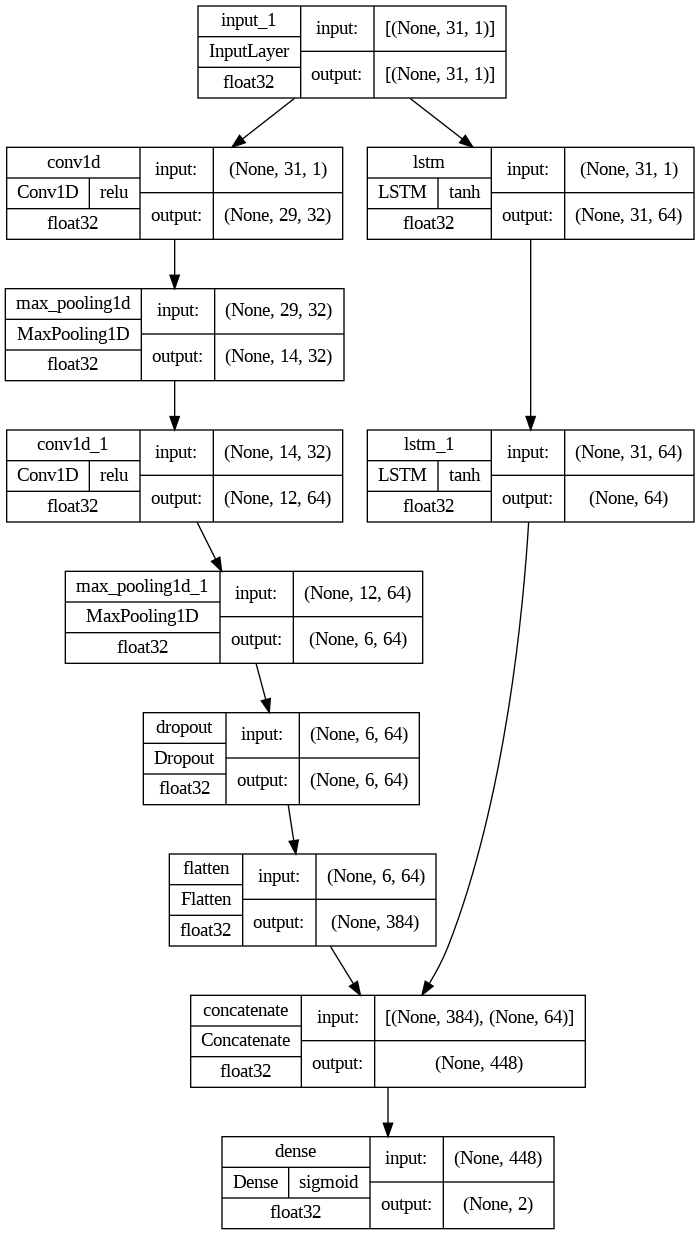

In [ ]:
plot_model(model, to_file="Hybrid Model Architecture IoTID20.png",show_shapes=True,show_dtype=True,show_layer_activations=True,show_layer_names=True)

In [ ]:
history = model.fit(X_train_IoTID20, ytrain, epochs=100, batch_size=256, verbose=1, callbacks=callbacks_list)

Epoch 1/100
33/37 [=========================>....] - ETA: 0s - loss: 0.6669 - accuracy: 0.6297
Epoch 1: accuracy improved from -inf to 0.62582, saving model to best-model-IoTID20.hdf5
37/37 [==============================] - 14s 12ms/step - loss: 0.6639 - accuracy: 0.6258
Epoch 2/100
35/37 [===========================>..] - ETA: 0s - loss: 0.5873 - accuracy: 0.6882
Epoch 2: accuracy improved from 0.62582 to 0.69218, saving model to best-model-IoTID20.hdf5
37/37 [==============================] - 0s 9ms/step - loss: 0.5846 - accuracy: 0.6922
Epoch 3/100
33/37 [=========================>....] - ETA: 0s - loss: 0.4836 - accuracy: 0.8041
Epoch 3: accuracy improved from 0.69218 to 0.80613, saving model to best-model-IoTID20.hdf5
37/37 [==============================] - 0s 10ms/step - loss: 0.4794 - accuracy: 0.8061
Epoch 4/100
32/37 [========================>.....] - ETA: 0s - loss: 0.3980 - accuracy: 0.8372
Epoch 4: accuracy improved from 0.80613 to 0.83718, saving model to best-model-IoTI

In [ ]:
random_seed_function()
t1 = time.time()
Y_pred_test = model.predict(np.vstack([X_train_IoTID20,X_test_IoTID20,X_train_IoTID20]))
t2 = time.time()
y_pred_test = np.argmax(Y_pred_test, axis=1)
Y_test = np.argmax(np.vstack([ytrain,ytest,ytrain]), axis=1)

HybridModel_accuracy_IoTID20 = accuracy_score(Y_test, y_pred_test) * 100
HybridModel_precision_IoTID20 = precision_score(Y_test, y_pred_test) * 100
HybridModel_recall_IoTID20 = recall_score(Y_test, y_pred_test) * 100
HybridModel_f1_IoTID20 = f1_score(Y_test, y_pred_test) * 100
print("HybridModel_IoTID20 Accuracy: {:.7f}".format(HybridModel_accuracy_IoTID20))
print("HybridModel_IoTID20 Precision: {:.7f}".format(HybridModel_precision_IoTID20))
print("HybridModel_IoTID20 Recall: {:.7f}".format(HybridModel_recall_IoTID20))
print("HybridModel_IoTID20 F1-Score: {:.7f}".format(HybridModel_f1_IoTID20))
print("HybridModel_IoTID20 Training Time: {:.5f} seconds".format(t2 - t1))

629/629 [==============================] - 3s 4ms/step
HybridModel_IoTID20 Accuracy: 99.8160942
HybridModel_IoTID20 Precision: 99.9433053
HybridModel_IoTID20 Recall: 99.7077677
HybridModel_IoTID20 F1-Score: 99.8253976
HybridModel_IoTID20 Training Time: 5.82882 seconds


### Hybrid Neural Networks (Hybrid Model) CICIDS2017

In [ ]:
X_train_cicids2017.shape, X_test_cicids2017.shape, y_train_cicids2017.shape, y_test_cicids2017.shape

((36252, 19), (5661, 19), (36252,), (5661,))

In [ ]:
ytrain = np_utils.to_categorical(y_train_cicids2017)
ytest = np_utils.to_categorical(y_test_cicids2017)
ytrain.shape, ytest.shape

((36252, 2), (5661, 2))

In [ ]:
samples, features = X_train_cicids2017.shape
classes = np.unique(y_test_cicids2017)
input_dimention = X_train_cicids2017.shape[1]
samples, features, classes, input_dimention

(36252, 19, array([0, 1]), 19)

In [ ]:
# Define input layer
inputs = Input(shape=(X_train_cicids2017.shape[1], 1))

with tf.device('/gpu:0'):
  random_seed_function()
  # Build CNN
  conv1 = Conv1D(filters=32, kernel_size=3, activation="relu")(inputs)
  pool1 = MaxPooling1D(pool_size=2)(conv1)
  conv2 = Conv1D(filters=64, kernel_size=3, activation="relu")(pool1)
  pool2 = MaxPooling1D(pool_size=2)(conv2)
  dropout1 = Dropout(rate=0.5)(pool2)
  flatten1 = tf.keras.layers.Flatten()(dropout1)

  # Build LSTM
  lstm1 = LSTM(units=64, return_sequences=True)(inputs)
  lstm2 = LSTM(units=64)(lstm1)

  # Concatenate CNN and LSTM
  concat = concatenate([flatten1, lstm2])

  # Build output layer
  outputs = Dense(units=len(classes), activation="sigmoid")(concat)

  # Define model
  model = Model(inputs=inputs, outputs=outputs)

In [ ]:
random_seed_function()
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

filepath = "best-model-CICIDS2017.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

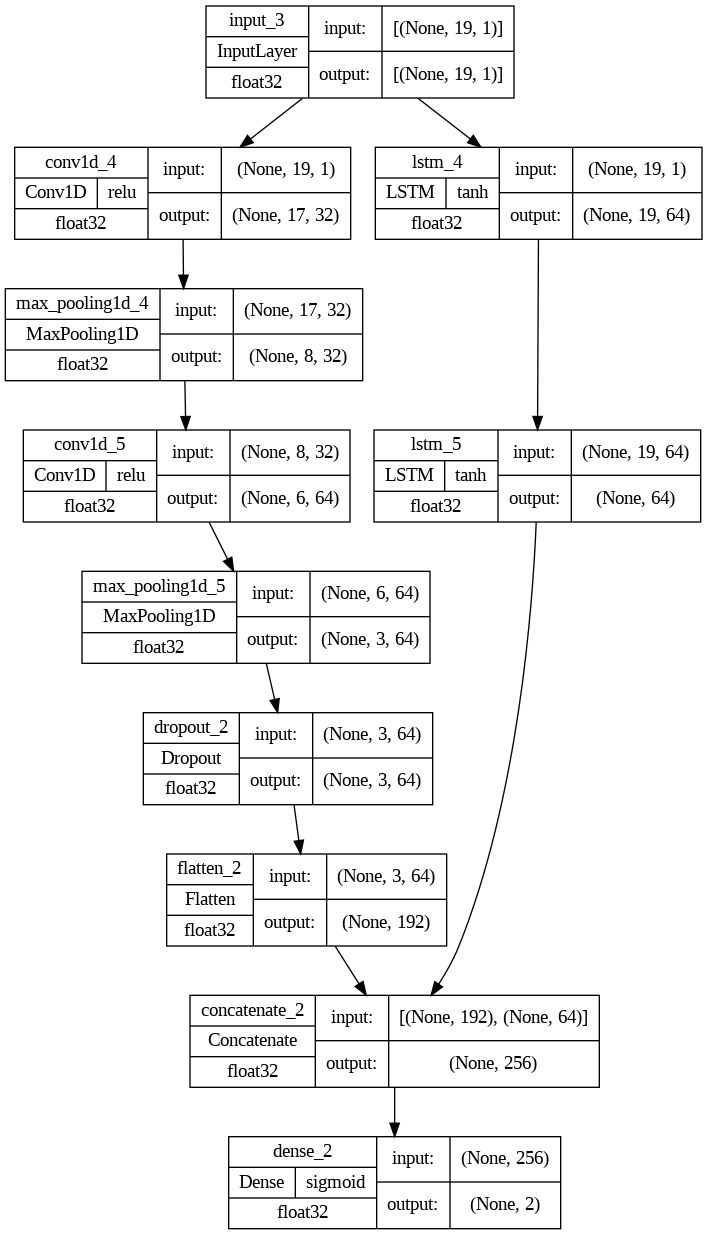

In [ ]:
plot_model(model, to_file="Hybrid Model Architecture CICIDS2017.png",show_shapes=True,show_dtype=True,show_layer_activations=True,show_layer_names=True)

In [ ]:
history = model.fit(X_train_cicids2017, ytrain, epochs=150, batch_size=256, verbose=1, callbacks=callbacks_list)

Epoch 1/150
141/142 [============================>.] - ETA: 0s - loss: 0.5879 - accuracy: 0.6433
Epoch 1: accuracy improved from -inf to 0.64339, saving model to best-model-CICIDS2017.hdf5
142/142 [==============================] - 4s 8ms/step - loss: 0.5877 - accuracy: 0.6434
Epoch 2/150
140/142 [============================>.] - ETA: 0s - loss: 0.4274 - accuracy: 0.8006
Epoch 2: accuracy improved from 0.64339 to 0.80114, saving model to best-model-CICIDS2017.hdf5
142/142 [==============================] - 1s 7ms/step - loss: 0.4267 - accuracy: 0.8011
Epoch 3/150
137/142 [===========================>..] - ETA: 0s - loss: 0.3389 - accuracy: 0.8449
Epoch 3: accuracy improved from 0.80114 to 0.84575, saving model to best-model-CICIDS2017.hdf5
142/142 [==============================] - 1s 7ms/step - loss: 0.3375 - accuracy: 0.8457
Epoch 4/150
138/142 [============================>.] - ETA: 0s - loss: 0.3118 - accuracy: 0.8583
Epoch 4: accuracy improved from 0.84575 to 0.85855, saving mode

In [ ]:
random_seed_function()
t1 = time.time()
Y_pred_test = model.predict(np.vstack([X_train_cicids2017,X_test_cicids2017,X_train_cicids2017]))
t2 = time.time()
y_pred_test = np.argmax(Y_pred_test, axis=1)
Y_test = np.argmax(np.vstack([ytrain,ytest,ytrain]), axis=1)

HybridModel_accuracy_CICIDS2017 = accuracy_score(Y_test, y_pred_test) * 100
HybridModel_precision_CICIDS2017 = precision_score(Y_test, y_pred_test) * 100
HybridModel_recall_CICIDS2017 = recall_score(Y_test, y_pred_test) * 100
HybridModel_f1_CICIDS2017 = f1_score(Y_test, y_pred_test) * 100
print("HybridModel_CICIDS2017 Accuracy: {:.7f}".format(HybridModel_accuracy_CICIDS2017))
print("HybridModel_CICIDS2017 Precision: {:.7f}".format(HybridModel_precision_CICIDS2017))
print("HybridModel_CICIDS2017 Recall: {:.7f}".format(HybridModel_recall_CICIDS2017))
print("HybridModel_CICIDS2017 F1-Score: {:.7f}".format(HybridModel_f1_CICIDS2017))
print("HybridModel_CICIDS2017 Training Time: {:.5f} seconds".format(t2 - t1))

2443/2443 [==============================] - 12s 4ms/step
HybridModel_CICIDS2017 Accuracy: 97.3082582
HybridModel_CICIDS2017 Precision: 96.0735651
HybridModel_CICIDS2017 Recall: 98.3920593
HybridModel_CICIDS2017 F1-Score: 97.2189912
HybridModel_CICIDS2017 Training Time: 21.44392 seconds


## <div class="alert alert-success">Visualization of simulation results starts here.</div>

In [ ]:
IoTID20_Model = ["Hybrid Deep Model", "Linear Discriminant Analysis", "Quadratic Discriminant Analysis", "Support Vector Machine", "Multi-Layer Preceptron"]
IoTID20_Accuracies = [HybridModel_accuracy_IoTID20, LDA_accuracy_IoTID20, QDA_accuracy_IoTID20, SVM_accuracy_IoTID20, MLP_accuracy_IoTID20]
IoTID20_Precisions = [HybridModel_precision_IoTID20, LDA_precision_IoTID20, QDA_precision_IoTID20, SVM_precision_IoTID20, MLP_precision_IoTID20]
IoTID20_Recalls = [HybridModel_recall_IoTID20, LDA_recall_IoTID20, QDA_recall_IoTID20, SVM_recall_IoTID20, MLP_recall_IoTID20]
IoTID20_F1 = [HybridModel_f1_IoTID20, LDA_f1_IoTID20, QDA_f1_IoTID20, SVM_f1_IoTID20, MLP_f1_IoTID20]

In [ ]:
CICIDS2017_Model = ["Hybrid Deep Model", "Linear Discriminant Analysis", "Quadratic Discriminant Analysis", "Support Vector Machine", "Multi-Layer Preceptron"]
CICIDS2017_Accuracies = [HybridModel_accuracy_CICIDS2017, LDA_accuracy_CICIDS2017, QDA_accuracy_CICIDS2017, SVM_accuracy_CICIDS2017, MLP_accuracy_CICIDS2017]
CICIDS2017_Precisions = [HybridModel_precision_CICIDS2017, LDA_precision_CICIDS2017, QDA_precision_CICIDS2017, SVM_precision_CICIDS2017, MLP_precision_CICIDS2017]
CICIDS2017_Recalls = [HybridModel_recall_CICIDS2017, LDA_recall_CICIDS2017, QDA_recall_CICIDS2017, SVM_recall_CICIDS2017, MLP_recall_CICIDS2017]
CICIDS2017_F1 = [HybridModel_f1_CICIDS2017, LDA_f1_CICIDS2017, QDA_f1_CICIDS2017, SVM_f1_CICIDS2017, MLP_f1_CICIDS2017]

# Accuracies plot on IoTID20 Dataset

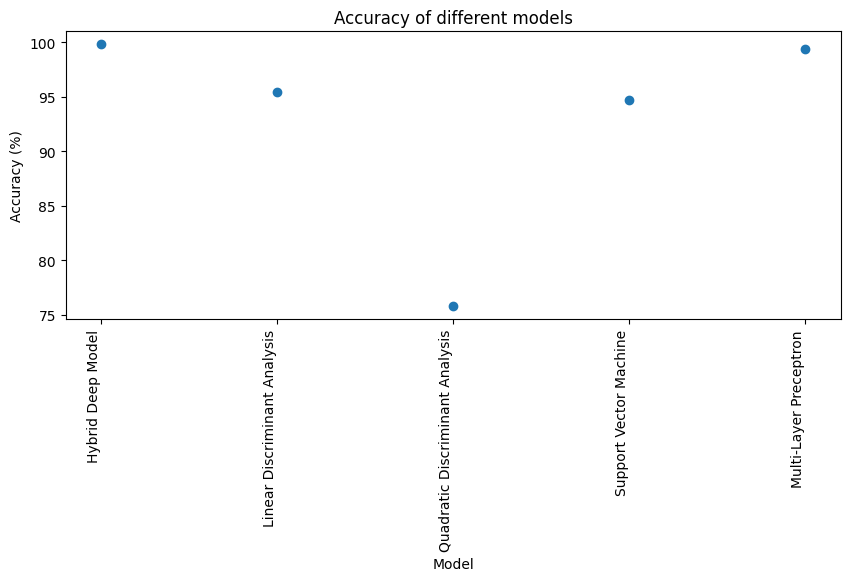

In [ ]:
import matplotlib.pyplot as plt

IoTID20_Model__ = ["Hybrid Deep Model", "Linear Discriminant Analysis", "Quadratic Discriminant Analysis", "Support Vector Machine", "Multi-Layer Preceptron"]
IoTID20_Accuracies__ = [HybridModel_accuracy_IoTID20,  LDA_accuracy_IoTID20, QDA_accuracy_IoTID20, SVM_accuracy_IoTID20, MLP_accuracy_IoTID20]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(IoTID20_Model__, IoTID20_Accuracies__)
plt.subplots_adjust(bottom=0.4)
ax.set_xticklabels(IoTID20_Model__, rotation=90, ha="right")
plt.subplots_adjust(bottom=0.4)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of different models')

plt.savefig('Accuracies_IoTID20.png')
plt.show()


# Accuracies plot on CICIDS2017 Dataset

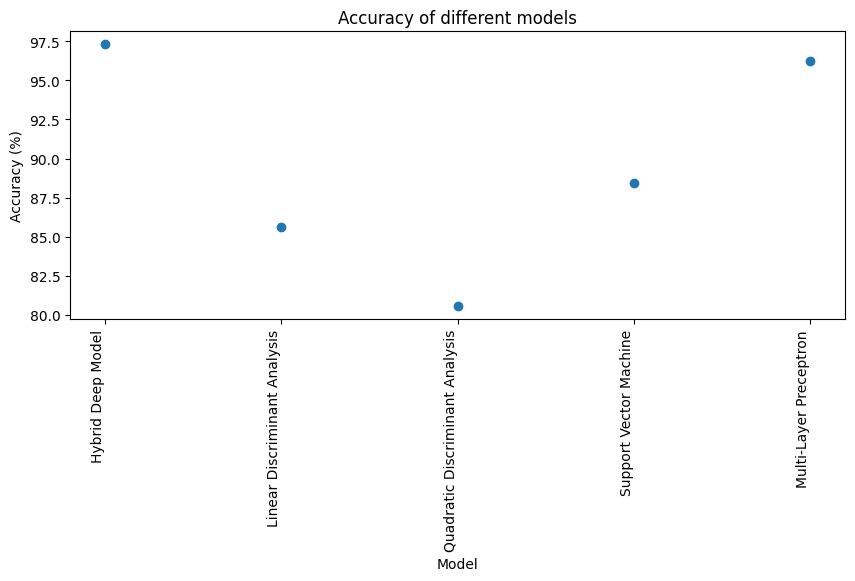

In [ ]:
import matplotlib.pyplot as plt

CICIDS2017_Model__ = ["Hybrid Deep Model", "Linear Discriminant Analysis", "Quadratic Discriminant Analysis", "Support Vector Machine", "Multi-Layer Preceptron"]
CICIDS2017_Accuracies__ = [HybridModel_accuracy_CICIDS2017, LDA_accuracy_CICIDS2017, QDA_accuracy_CICIDS2017, SVM_accuracy_CICIDS2017, MLP_accuracy_CICIDS2017]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(CICIDS2017_Model__, CICIDS2017_Accuracies__)
plt.subplots_adjust(bottom=0.4)
ax.set_xticklabels(CICIDS2017_Model__, rotation=90, ha="right")
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of different models')

plt.savefig('Accuracies_CICIDS2017.png')
plt.show()


# Complete Table of IoTID20 Dataset

In [ ]:
from tabulate import tabulate

table_data = []
for i in range(len(IoTID20_Model)):
    table_data.append([IoTID20_Model[i], IoTID20_Accuracies[i], IoTID20_Precisions[i], IoTID20_Recalls[i], IoTID20_F1[i]])

print(tabulate(table_data, headers=["Model (IoTID20 Dataset)", "Accuracy", "Precision Score", "Recall Score", "F-1 Score"], tablefmt="fancy_grid"))

╒═════════════════════════════════╤════════════╤═══════════════════╤════════════════╤═════════════╕
│ Model (IoTID20 Dataset)         │   Accuracy │   Precision Score │   Recall Score │   F-1 Score │
╞═════════════════════════════════╪════════════╪═══════════════════╪════════════════╪═════════════╡
│ Hybrid Deep Model               │    99.8161 │           99.9433 │        99.7078 │     99.8254 │
├─────────────────────────────────┼────────────┼───────────────────┼────────────────┼─────────────┤
│ Linear Discriminant Analysis    │    95.4437 │           99.3811 │        95.7411 │     97.5271 │
├─────────────────────────────────┼────────────┼───────────────────┼────────────────┼─────────────┤
│ Quadratic Discriminant Analysis │    75.7794 │           99.8854 │        74.276  │     85.1979 │
├─────────────────────────────────┼────────────┼───────────────────┼────────────────┼─────────────┤
│ Support Vector Machine          │    94.7242 │           99.2007 │        95.1448 │     97.1304 │


# Complete Table of CICIDS2017 Dataset

In [ ]:
from tabulate import tabulate

table_data = []
for i in range(len(CICIDS2017_Model)):
    table_data.append([CICIDS2017_Model[i], CICIDS2017_Accuracies[i], CICIDS2017_Precisions[i], CICIDS2017_Recalls[i], CICIDS2017_F1[i]])

print(tabulate(table_data, headers=["Model (CICIDS2017 Dataset)", "Accuracy", "Precision Score", "Recall Score", "F-1 Score"], tablefmt="fancy_grid"))

╒═════════════════════════════════╤════════════╤═══════════════════╤════════════════╤═════════════╕
│ Model (CICIDS2017 Dataset)      │   Accuracy │   Precision Score │   Recall Score │   F-1 Score │
╞═════════════════════════════════╪════════════╪═══════════════════╪════════════════╪═════════════╡
│ Hybrid Deep Model               │    97.3083 │           96.0736 │        98.3921 │     97.219  │
├─────────────────────────────────┼────────────┼───────────────────┼────────────────┼─────────────┤
│ Linear Discriminant Analysis    │    85.6033 │           58.5825 │        94.0444 │     72.1938 │
├─────────────────────────────────┼────────────┼───────────────────┼────────────────┼─────────────┤
│ Quadratic Discriminant Analysis │    80.5335 │           50.5351 │        96.5333 │     66.3409 │
├─────────────────────────────────┼────────────┼───────────────────┼────────────────┼─────────────┤
│ Support Vector Machine          │    88.4473 │           64.0262 │        95.5556 │     76.6762 │


# Precision, REcall, F1 Score bar plot for IoTID20 Dataset

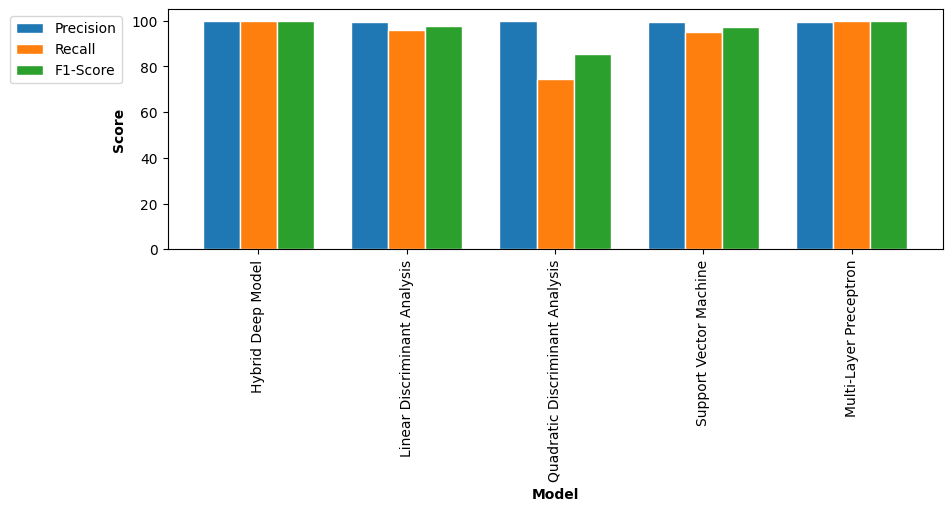

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


model_names = IoTID20_Model

bar_width = 0.25

r1 = np.arange(len(IoTID20_Precisions))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(10,5))

plt.bar(r1, IoTID20_Precisions, color='#1f77b4', width=bar_width, edgecolor='white', label='Precision')
plt.bar(r2, IoTID20_Recalls, color='#ff7f0e', width=bar_width, edgecolor='white', label='Recall')
plt.bar(r3, IoTID20_F1, color='#2ca02c', width=bar_width, edgecolor='white', label='F1-Score')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(IoTID20_Precisions))], model_names, rotation=90)
plt.subplots_adjust(bottom=0.4)

plt.ylabel('Score', fontweight='bold')
plt.legend(bbox_to_anchor=(-0.05, 1))
plt.savefig('P_R_F_IoTID20.png')

plt.show()

# Precision, REcall, F1 Score bar plot for CICIDS2017 Dataset

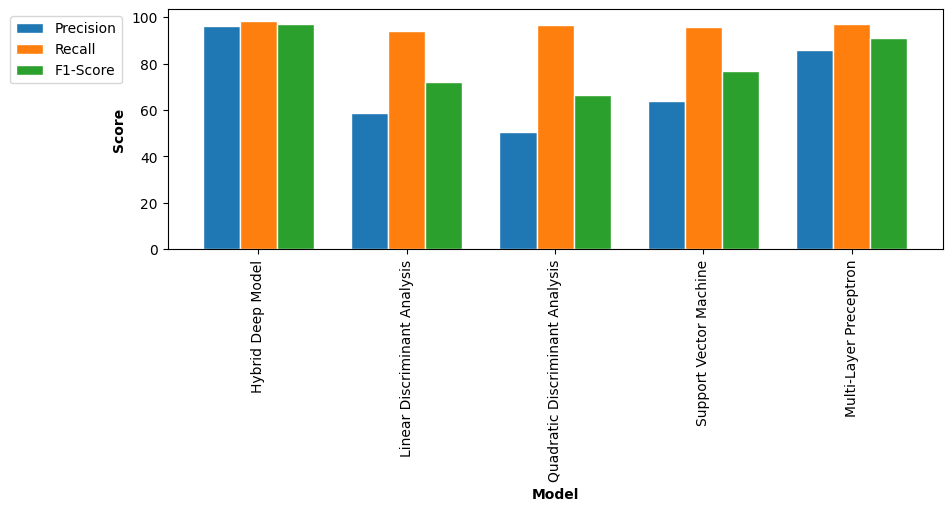

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


model_names = CICIDS2017_Model

bar_width = 0.25

r1 = np.arange(len(CICIDS2017_Precisions))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(10,5))

plt.bar(r1, CICIDS2017_Precisions, color='#1f77b4', width=bar_width, edgecolor='white', label='Precision')
plt.bar(r2, CICIDS2017_Recalls, color='#ff7f0e', width=bar_width, edgecolor='white', label='Recall')
plt.bar(r3, CICIDS2017_F1, color='#2ca02c', width=bar_width, edgecolor='white', label='F1-Score')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(CICIDS2017_Precisions))], model_names, rotation=90)
plt.subplots_adjust(bottom=0.4)

plt.ylabel('Score', fontweight='bold')
plt.legend(bbox_to_anchor=(-0.05, 1))

plt.savefig('P_R_F_CICIDS2017.png')
plt.show()